In [16]:
#!pip install pycocotools


In [17]:

#!kaggle datasets download -d awsaf49/coco-2017-dataset -p /content/drive/My\ Drive/COMP9444_project/
#!unzip /content/drive/MyDrive/COMP9444_project/coco-2017-dataset.zip -d /content/drive/MyDrive/COMP9444_project/data


In [18]:
#BASE_PATH= '/content/drive/MyDrive/COMP9444_project/data/coco2017'
BASE_PATH= 'coco2017'
# !pip install -q kaggle
# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir -p ~/.kaggle
# !cp /content/drive/My\ Drive/COMP9444_project/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [80]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import string

设置路径

In [20]:
from typing import Annotated
from pycocotools.coco import COCO

train_img_file=os.path.join(BASE_PATH,'train2017')
test_img_file=os.path.join(BASE_PATH,'test2017')
val_img_file=os.path.join(BASE_PATH,'val2017')

anno_file=os.path.join(BASE_PATH,'annotations')
train_file=os.path.join(anno_file,'captions_train2017.json')
val_file=os.path.join(anno_file,'captions_val2017.json')

In [21]:
coco_train=COCO(train_file)
coco_val=COCO(val_file)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


加载图片id和信息

In [22]:
train_img_id=coco_train.getImgIds()
train_img_info=coco_train.loadImgs(train_img_id)
val_img_id=coco_val.getImgIds()
val_img_info=coco_val.loadImgs(val_img_id)
print(train_img_id[0])
print(train_img_info[0])
print(val_img_id[0])
print(val_img_info[0])

391895
{'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}
397133
{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}


图片地址和注释

In [141]:
def load_data(val=False,part=0):
    data_list=[]
    random.seed(10)
    if val:
        ids=val_img_id
        data=coco_val
        file=val_img_file
    
    else:
        ids=train_img_id
        data=coco_train
        file=train_img_file
        
    if part>0:
        num=len(ids) // part
        ids=random.sample(ids,num)
    
    for id in ids:
    
        annid=data.getAnnIds(id)
        anns=data.loadAnns(annid)
        caption=[ann['caption'] for ann in anns]
        img_path=os.path.join(file,"{:012d}.jpg".format(id))
        data_list.append([img_path,caption,id])


    
    return data_list

In [142]:
print(len(train_img_id),len(val_img_id))

118287 5000


In [143]:
train_data_list = load_data(False,10)
val_data_list = load_data(True,10)
print(len(train_data_list[:]))
print(len(val_data_list[:]))


11828
500


In [144]:
train_data_list[0]

['coco2017\\train2017\\000000132574.jpg',
 ['three small children huddle together under an umbrella',
  'group of kids standing on road',
  'the three little girls are dressed in bright raingear in the country setting',
  'some very small children standing under an umbrella',
  'three young girls talk while under the umbrella'],
 132574]

id打印注释和图片


In [145]:
def show_img(id,val=False):
    random.seed(10)
    if val:
        data=coco_val
        file=val_img_file
    else:
        data=coco_train
        file=train_img_file

    annid=data.getAnnIds(id)
    #print(annid)
    anns=data.loadAnns(annid)
    data.showAnns(anns)
    img_path=os.path.join(file,"{:012d}.jpg".format(id))
    pic=cv2.imread(img_path)
    plt.imshow(pic)
    plt.axis('off')
    plt.show()

In [146]:
print(train_data_list[0][2])
for id in coco_train.getAnnIds(train_data_list[0][2]):
    print(coco_train.anns[id]['caption'])

132574
three small children huddle together under an umbrella
group of kids standing on road
the three little girls are dressed in bright raingear in the country setting
some very small children standing under an umbrella
three young girls talk while under the umbrella


three small children huddle together under an umbrella
group of kids standing on road
the three little girls are dressed in bright raingear in the country setting
some very small children standing under an umbrella
three young girls talk while under the umbrella


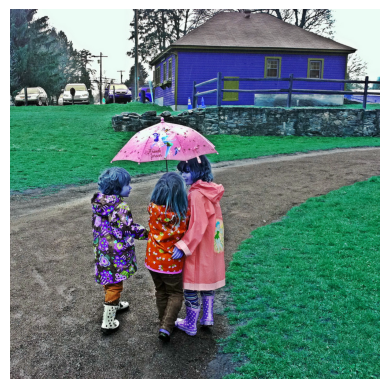

In [147]:
show_img(train_data_list[0][2])

In [148]:
# ref: https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/
def txt_preprocess(data_list,val=False):
    if val:
        data=coco_val
        file=val_img_file
    else:
        data=coco_train
        file=train_img_file

    
    
    table = str.maketrans('','',string.punctuation)  #remove all punctuation 
    for i, item in enumerate(data_list):
        caption_list = data.getAnnIds(item[2])
       
        for j,sentence in enumerate(item[1]):
            
            
            sentence.replace("-"," ")
            # remove punctuation
            sentence = sentence.translate(table)
            split_sentence = sentence.split()
            # convert all to lower case
            split_sentence = [wrd.lower() for wrd in split_sentence]
            # remove 's and a that does not help with training
            split_sentence = [wrd for wrd in split_sentence if(len(wrd)>1)]
            # remove all string like numbers
            split_sentence = [wrd for wrd in split_sentence if(wrd.isalpha())]
            sentence = ' '.join(split_sentence)
            item[1][j] = sentence
            #store back annotation 
            data.anns[caption_list[j]]['caption'] = sentence
        data_list[i][1] = item[1]
        
    return data_list
train_data_list = txt_preprocess(train_data_list)

three small children huddle together under an umbrella
group of kids standing on road
the three little girls are dressed in bright raingear in the country setting
some very small children standing under an umbrella
three young girls talk while under the umbrella


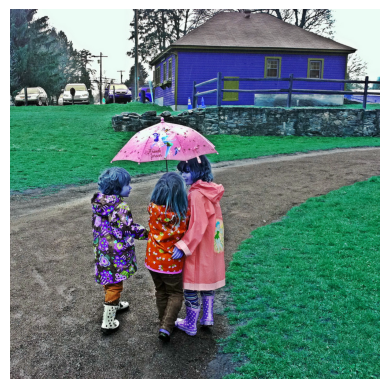

In [149]:
show_img(train_data_list[0][2])